### Make paths to directories

In [25]:
import sys
import os

# Get the path to the current working directory
current_dir = os.getcwd()

# Get the path to the parent directory (containing both A.py and 'B' directory)
parent_dir = os.path.dirname(current_dir)

london_data_dir = os.path.join(parent_dir, 'Data/London_dataset/preprocessed')
results_dir = os.path.join(current_dir, 'results')
# Append the parent directory to the module search path
sys.path.append(parent_dir)
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator

### Imports

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator
from data_preprocessing.get_buffer_attributes import BufferAttributesCalculator

import numpy as np
import pandas as pd
import pickle
import datetime
import inspect
from pathlib import Path


### DATA generators

In [28]:
def get_meterids_with_NaNs(df):
    meterids_with_nans = set()
    for meterid, row in df.iterrows():
        if row.isna().any():
            meterids_with_nans.add(meterid)
    return meterids_with_nans

In [29]:
random_gen = np.random.default_rng(12341)

def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 24*4))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

def london_dataset(london_data_dir=london_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl"):
    #return [], [], []
    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    return attributes, timeseries, folds

def london_dataset_with_buffer(buffer_attributes, london_data_dir = london_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl", weekdays_only = True):
    return [], [], []

    attributes_path = os.path.join(london_data_dir, attributes) #combined_attributes_filtered.pkl
    buffer_attributes_path = os.path.join(london_data_dir, buffer_attributes) #daily_data_df_filtered.pkl
    timeseries_path = os.path.join(london_data_dir, timeseries) #buffer_attributes_march_df.pkl
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    buffer_attributes = pd.read_pickle(buffer_attributes_path)
    merged_attributes = attributes.merge(buffer_attributes,on=['meterID'], how="left")
    
    merged_attributes = merged_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])
    to_drop = get_meterids_with_NaNs(merged_attributes)
    combined_attributes = merged_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(combined_attributes), dtype= 'int'), 5)

    return combined_attributes, timeseries, folds

In [30]:
def generate_dataset_with_2_buffer(buffer_attributes1, buffer_attributes2,start,end, london_data_dir = london_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl"):
    return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes) 
    buffer_attributes1_path = os.path.join(london_data_dir, buffer_attributes1)
    buffer_attributes2_path = os.path.join(london_data_dir, buffer_attributes2)
    timeseries_path = os.path.join(london_data_dir, timeseries) 
    
    timeseries = pd.read_pickle(timeseries_path)


    # Read data into DataFrames
    attributes = pd.read_pickle(attributes_path)
    buffer_attributes1 = pd.read_pickle(buffer_attributes1_path)
    buffer_attributes2 = pd.read_pickle(buffer_attributes2_path)
    
    # Add a new column to the original attributes DataFrame
    attributes['row_index'] = range(len(attributes))
    
    # Filter attributes DataFrame
    attributes1 = attributes[attributes['dayOfYear'].between(start,end)]
    attributes2 = attributes[~attributes['dayOfYear'].between(start,end)]
    
    # Merge DataFrames
    merged_attributes1 = attributes1.merge(buffer_attributes1, on=['meterID'], how="left")
    merged_attributes2 = attributes2.merge(buffer_attributes2, on=['meterID'], how="left")
    
    # Combine merged DataFrames
    combined_attributes = pd.concat([merged_attributes1, merged_attributes2])
    
    # Sort DataFrame based on the new column 'row_index'
    combined_attributes.sort_values(by='row_index', inplace=True)
    
    # Drop the 'row_index' column
    combined_attributes.drop(columns='row_index', inplace=True)
    combined_attributes = combined_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])
    
    to_drop = get_meterids_with_NaNs(combined_attributes)
    combined_attributes = combined_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(combined_attributes), dtype= 'int'), 5)

    
    return combined_attributes, timeseries, folds, True, start, end

In [31]:
def generate_dataset_with_2_baseline(start,end, london_data_dir = london_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl"):
    return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)

    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    
    return attributes, timeseries, folds, True, start, end

In [32]:
def get_NaNs(df):
    NaN_counts = df.isna().sum()
    for column_name, na_count in NaN_counts.items():
        if na_count > 0:
            print(f"Column {column_name} has {na_count} missing values.")
 

# Parameter tuning

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('results/Tuning'), nb_of_samples = 250)
    .add_methods(
        PCT_D6_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 100)),
        PCT_D8_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 100)),
        PCT_D10_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100)),
        PCT_D6_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 175)),
        PCT_D8_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 175)),
        PCT_D10_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 175)),
        PCT_D6_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 250)),
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        PCT_D10_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 350)),
        PCT_D12_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 250)),
        PCT_D12_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 350)),
        PCT_D14_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 14, min_samples_leaf = 450)),
        PCT_D6_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 450)),
        PCT_D8_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 450)),
        PCT_D6_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 650)),
        PCT_D8_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 650)),
        PCT_D6_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 850)),
        PCT_D9_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 450)),
        PCT_D7_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 450)),
        PCT_D9_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 650)),
        PCT_D7_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 650)),
        PCT_D9_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 250)),
        PCT_D7_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 250)),
        PCT_D8_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 850)),

    )
    .add_datasets(
        London_dataset_baseline =london_dataset(),
        )
)

energy_scores, timing_df = experiment.execute()

Methods: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s, method=PCT_D8_M850] 


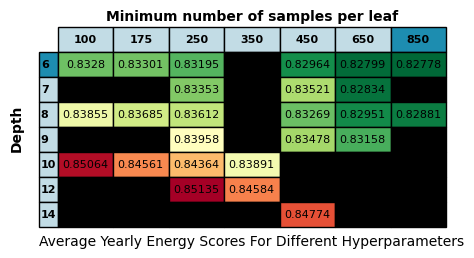

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(2.8, 2.7))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(-0.55, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('Pictures/tuninglondonbaseline.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('results/Tuning'), nb_of_samples = 250)
    .add_methods(
        PCT_D6_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 850)),
        PCT_D8_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 850)),
        PCT_D7_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 850)),
        PCT_D9_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 850)),
        PCT_D10_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 850)),
    )
    .add_datasets(
        london_dataset_with_buffer_nov = london_dataset_with_buffer('buffer_attributes_month_11_catch22_df.pkl'),
        )
)

energy_scores, timing_df = experiment.execute()

Methods: 100%|██████████| 5/5 [00:00<00:00,  7.95it/s, method=PCT_D10_M850]


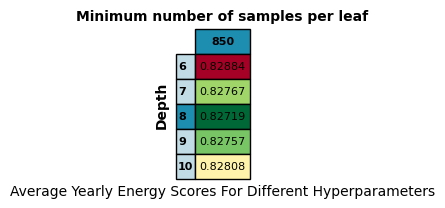

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(2.8, 2.1))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(0.25, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('Pictures/tuninglondon.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


# ThesisResults

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('results/ThesisResults'), nb_of_samples = 250)
    .add_methods(
        Random_Baseline = RandomGenerator(),
        PCT_D6_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 850)),
    )
    .add_datasets(
        london_dataset_baseline = london_dataset(),
        )
)

energy_scores, timing_df = experiment.execute()


Methods: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s, method=PCT_D6_M850]    


In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('results/ThesisResults'), nb_of_samples = 250)
    .add_methods(
        PCT_D8_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 850)),
    )
    .add_datasets(
        london_dataset_with_buffer_jan = london_dataset_with_buffer('buffer_attributes_month_1_catch22_df.pkl'),
        london_dataset_with_buffer_feb = london_dataset_with_buffer('buffer_attributes_month_2_catch22_df.pkl'),
        london_dataset_with_buffer_mar = london_dataset_with_buffer('buffer_attributes_month_3_catch22_df.pkl'),
        london_dataset_with_buffer_apr = london_dataset_with_buffer('buffer_attributes_month_4_catch22_df.pkl'),
        london_dataset_with_buffer_may = london_dataset_with_buffer('buffer_attributes_month_5_catch22_df.pkl'),
        london_dataset_with_buffer_jun = london_dataset_with_buffer('buffer_attributes_month_6_catch22_df.pkl'),
        london_dataset_with_buffer_jul = london_dataset_with_buffer('buffer_attributes_month_7_catch22_df.pkl'),
        london_dataset_with_buffer_aug = london_dataset_with_buffer('buffer_attributes_month_8_catch22_df.pkl'),
        london_dataset_with_buffer_sep = london_dataset_with_buffer('buffer_attributes_month_9_catch22_df.pkl'),
        london_dataset_with_buffer_oct = london_dataset_with_buffer('buffer_attributes_month_10_catch22_df.pkl'),
        london_dataset_with_buffer_nov = london_dataset_with_buffer('buffer_attributes_month_11_catch22_df.pkl'),
        london_dataset_with_buffer_dec = london_dataset_with_buffer('buffer_attributes_month_12_catch22_df.pkl'),
         )
)
energy_scores2, timing_df2 = experiment.execute()
energy_scores = pd.concat([energy_scores, energy_scores2], axis=1)


Methods: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, method=PCT_D8_M850]


In [46]:
mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
display(sorted_es)

ES
PCT_D8_M850     london_dataset_with_buffer_feb  0.821001
                london_dataset_with_buffer_jul  0.822239
                london_dataset_with_buffer_oct  0.822633
                london_dataset_with_buffer_jun  0.823018
                london_dataset_with_buffer_apr  0.823854
                london_dataset_with_buffer_sep  0.824112
                london_dataset_with_buffer_may  0.824235
                london_dataset_with_buffer_mar  0.824434
                london_dataset_with_buffer_aug  0.825469
                london_dataset_with_buffer_jan  0.825934
                london_dataset_with_buffer_dec  0.826315
                london_dataset_with_buffer_nov  0.827188
PCT_D6_M850     london_dataset_baseline         0.827821
Random_Baseline london_dataset_baseline         1.003009

# Experiments Interface

### Plot results

In [47]:
# set the correct index to the energy scores
ldf = london_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')
energy_scores.index

Index([2013-01-01, 2013-01-02, 2013-01-03, 2013-01-04, 2013-01-05, 2013-01-06,
       2013-01-07, 2013-01-08, 2013-01-09, 2013-01-10,
       ...
       2013-12-22, 2013-12-23, 2013-12-24, 2013-12-25, 2013-12-26, 2013-12-27,
       2013-12-28, 2013-12-29, 2013-12-30, 2013-12-31],
      dtype='object', name='date', length=811030)

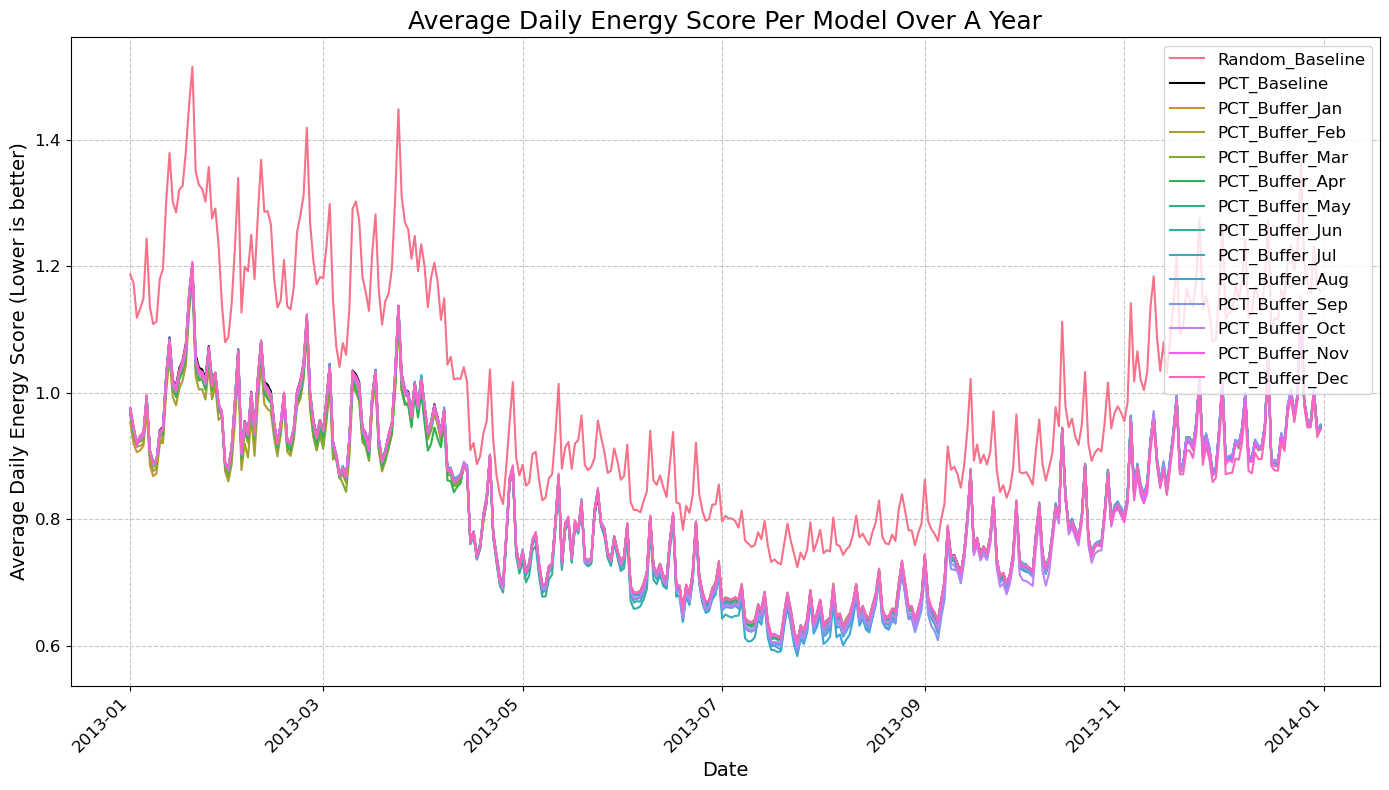

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'date' and calculate the mean and standard deviation for each day
df_avg = energy_scores.groupby('date').mean()
# df_std = energy_scores.groupby('date').std()

# Set a seaborn color palette
sns.set_palette("husl", len(df_avg.columns))

# Custom legend names
custom_legend_names = [
    'Random_Baseline',    
    'PCT_Baseline',       
    'PCT_Buffer_Jan',
    'PCT_Buffer_Feb',
    'PCT_Buffer_Mar',
    'PCT_Buffer_Apr',
    'PCT_Buffer_May',
    'PCT_Buffer_Jun',
    'PCT_Buffer_Jul',
    'PCT_Buffer_Aug',
    'PCT_Buffer_Sep',
    'PCT_Buffer_Oct',
    'PCT_Buffer_Nov',
    'PCT_Buffer_Dec'
]

# Plot the averages for all columns dynamically with different colors
plt.figure(figsize=(14, 8))

# Iterate over all columns and plot them with different colors
for i, column in enumerate(df_avg.columns):
    color = sns.color_palette()[i]  # Use seaborn color palette
    if i == 1:
        color = 'black'
    plt.plot(df_avg.index, df_avg[column], linestyle='-', color=color, label=custom_legend_names[i])

# Set plot aesthetics
plt.title('Average Daily Energy Score Per Model Over A Year', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Daily Energy Score (Lower is better)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('pictures/londonyeargraph.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [215]:
for i in range(1,13):
    technique_A = df_avg.iloc[:, 1]
    technique_B = df_avg.iloc[:, i]
    percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
    percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
    print("lower in A: ", percentage_A_greater_than_B)

lower in A:  0.0
lower in A:  54.794520547945204
lower in A:  76.43835616438356
lower in A:  51.23287671232877
lower in A:  72.05479452054794
lower in A:  81.91780821917808
lower in A:  80.0
lower in A:  76.71232876712328
lower in A:  54.52054794520548
lower in A:  63.83561643835617
lower in A:  85.47945205479452
lower in A:  56.71232876712329


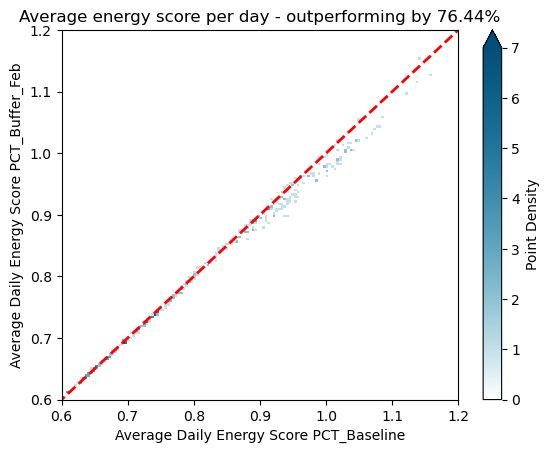

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 1]
technique_B = df_avg.iloc[:, 3]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Feb')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(0.6, 1.2)
plt.ylim(0.6, 1.2)
# Show the plot
plt.savefig('pictures/londondailycomparison.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

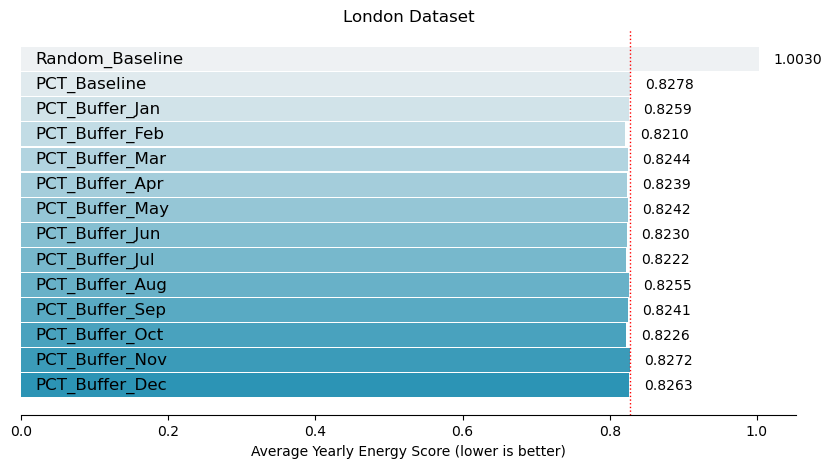

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
extended_list = [f'PCT_Buffer_{month}' for month in months]
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques.extend(extended_list)

# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('London Dataset')
plt.savefig('pictures/energy_score_comparison_london.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()


In [51]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
energy_scores = energy_scores.drop(energy_scores.columns[0], axis=1)
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')

# Rename the index for clarity
monthly_means.index = ['PCT_Baseline', 'PCT_Buffer_Jan', 'PCT_Buffer_Feb', 'PCT_Buffer_Mar', 'PCT_Buffer_Apr', 'PCT_Buffer_May', 'PCT_Buffer_Jun', 'PCT_Buffer_Jul', 'PCT_Buffer_Aug', 'PCT_Buffer_Sep', 'PCT_Buffer_Oct', 'PCT_Buffer_Nov', 'PCT_Buffer_Dec']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,0.998111,0.981716,0.969264,0.843962,0.760694,0.713534,0.647142,0.660159,0.737141,0.787182,0.898212,0.947803
PCT_Buffer_Jan,0.983319,0.974063,0.963433,0.841130,0.760795,0.714240,0.649340,0.662559,0.736573,0.787609,0.900336,0.948549
PCT_Buffer_Feb,0.975567,0.953040,0.951068,0.837613,0.759500,0.711594,0.647723,0.659653,0.733015,0.786511,0.898973,0.947214
PCT_Buffer_Mar,0.986522,0.964698,0.948368,0.838947,0.761452,0.715227,0.651307,0.664048,0.736033,0.787975,0.900232,0.948516
PCT_Buffer_Apr,0.988097,0.969925,0.955585,0.833259,0.760243,0.712520,0.646617,0.658679,0.734448,0.788132,0.899900,0.949258
PCT_Buffer_May,0.993493,0.976749,0.964025,0.839427,0.751374,0.706588,0.644847,0.658274,0.734384,0.787239,0.898132,0.947222
PCT_Buffer_Jun,0.995294,0.978224,0.965459,0.841713,0.754974,0.697170,0.638196,0.651877,0.729436,0.786057,0.900211,0.948640
PCT_Buffer_Jul,0.993713,0.977922,0.964688,0.843111,0.758506,0.701533,0.626973,0.646550,0.729178,0.786401,0.900675,0.948987
PCT_Buffer_Aug,0.995934,0.980723,0.969076,0.846374,0.762484,0.710623,0.634337,0.640685,0.733678,0.790589,0.902339,0.950296
PCT_Buffer_Sep,0.994505,0.978518,0.966198,0.845035,0.762544,0.705989,0.636537,0.646811,0.722921,0.787439,0.902430,0.951489


In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val):
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}'

# Apply the color mapping to each cell within its column
styled_table = monthly_means.style.apply(lambda x: [color_gradient(v, min(x), max(x)) for v in x], axis=0)

# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Baseline,0.998111,0.981716,0.969264,0.843962,0.760694,0.713534,0.647142,0.660159,0.737141,0.787182,0.898212,0.947803
January,0.983319,0.974063,0.963433,0.841130,0.760795,0.714240,0.649340,0.662559,0.736573,0.787609,0.900336,0.948549
February,0.975567,0.953040,0.951068,0.837613,0.759500,0.711594,0.647723,0.659653,0.733015,0.786511,0.898973,0.947214
March,0.986522,0.964698,0.948368,0.838947,0.761452,0.715227,0.651307,0.664048,0.736033,0.787975,0.900232,0.948516
April,0.988097,0.969925,0.955585,0.833259,0.760243,0.712520,0.646617,0.658679,0.734448,0.788132,0.899900,0.949258
May,0.993493,0.976749,0.964025,0.839427,0.751374,0.706588,0.644847,0.658274,0.734384,0.787239,0.898132,0.947222
June,0.995294,0.978224,0.965459,0.841713,0.754974,0.697170,0.638196,0.651877,0.729436,0.786057,0.900211,0.948640
July,0.993713,0.977922,0.964688,0.843111,0.758506,0.701533,0.626973,0.646550,0.729178,0.786401,0.900675,0.948987
August,0.995934,0.980723,0.969076,0.846374,0.762484,0.710623,0.634337,0.640685,0.733678,0.790589,0.902339,0.950296
September,0.994505,0.978518,0.966198,0.845035,0.762544,0.705989,0.636537,0.646811,0.722921,0.787439,0.902430,0.951489


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for v in x:
        style = color_gradient(v, min(x), max(x), base_val)
        if v < base_val:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_Baseline Comparison</b>"))

# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,0.99811,0.98172,0.96926,0.84396,0.76069,0.71353,0.64714,0.66016,0.73714,0.78718,0.89821,0.94780
PCT_Buffer_Jan,0.98332,0.97406,0.96343,0.84113,0.76080,0.71424,0.64934,0.66256,0.73657,0.78761,0.90034,0.94855
PCT_Buffer_Feb,0.97557,0.95304,0.95107,0.83761,0.75950,0.71159,0.64772,0.65965,0.73301,0.78651,0.89897,0.94721
PCT_Buffer_Mar,0.98652,0.96470,0.94837,0.83895,0.76145,0.71523,0.65131,0.66405,0.73603,0.78797,0.90023,0.94852
PCT_Buffer_Apr,0.98810,0.96992,0.95559,0.83326,0.76024,0.71252,0.64662,0.65868,0.73445,0.78813,0.89990,0.94926
PCT_Buffer_May,0.99349,0.97675,0.96402,0.83943,0.75137,0.70659,0.64485,0.65827,0.73438,0.78724,0.89813,0.94722
PCT_Buffer_Jun,0.99529,0.97822,0.96546,0.84171,0.75497,0.69717,0.63820,0.65188,0.72944,0.78606,0.90021,0.94864
PCT_Buffer_Jul,0.99371,0.97792,0.96469,0.84311,0.75851,0.70153,0.62697,0.64655,0.72918,0.78640,0.90068,0.94899
PCT_Buffer_Aug,0.99593,0.98072,0.96908,0.84637,0.76248,0.71062,0.63434,0.64069,0.73368,0.79059,0.90234,0.95030
PCT_Buffer_Sep,0.99450,0.97852,0.96620,0.84504,0.76254,0.70599,0.63654,0.64681,0.72292,0.78744,0.90243,0.95149


# 2 buffer results

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('results/ThesisResults2buffers'), nb_of_samples = 250)
    .add_methods(
        #predictive_clustering =  PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100)),
        PCT_D6_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 850)),

        #random_forest = PredClusGenerator(RandomForestRegressor(n_estimators=100, 
                                    #   max_depth=10, 
                                    #   min_samples_leaf=100, 
                                    #   random_state=42)),
        #random_baseline = RandomGenerator(),
    )
    .add_datasets(
        #random_dataset = random_dataset(1000),
        #deep_random_dataset = random_dataset(10000),
        London_Jan_Jul_baseline = generate_dataset_with_2_baseline(91,273),
        London_Feb_Aug_baseline = generate_dataset_with_2_baseline(122,304),
        London_Mar_Sep_baseline = generate_dataset_with_2_baseline(153, 335),
        London_Apr_Okt_baseline = generate_dataset_with_2_baseline(183, 365),
        London_May_Nov_baseline = generate_dataset_with_2_baseline(30,212),
        London_Jun_Dec_baseline = generate_dataset_with_2_baseline(61, 243),
         )
)

energy_scores, timing_df = experiment.execute()

Methods:   0%|          | 0/1 [00:00<?, ?it/s, method=PCT_D6_M850]

Methods: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, method=PCT_D6_M850]


In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('results/ThesisResults2buffers'), nb_of_samples = 250)
    .add_methods(
        PCT_D8_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 850)),
    )
    .add_datasets(
        
        London_Jan_Jul = generate_dataset_with_2_buffer('buffer_attributes_month_7_catch22_df.pkl', 'buffer_attributes_month_1_catch22_df.pkl',91,273),
        London_Feb_Aug = generate_dataset_with_2_buffer('buffer_attributes_month_8_catch22_df.pkl', 'buffer_attributes_month_2_catch22_df.pkl',122,304),
        London_Mar_Sep = generate_dataset_with_2_buffer('buffer_attributes_month_9_catch22_df.pkl', 'buffer_attributes_month_3_catch22_df.pkl', 153, 335),
        London_Apr_Okt = generate_dataset_with_2_buffer('buffer_attributes_month_10_catch22_df.pkl', 'buffer_attributes_month_4_catch22_df.pkl', 183, 365),
        London_May_Nov = generate_dataset_with_2_buffer('buffer_attributes_month_5_catch22_df.pkl', 'buffer_attributes_month_11_catch22_df.pkl',30,212),
        London_Jun_Dec = generate_dataset_with_2_buffer('buffer_attributes_month_6_catch22_df.pkl', 'buffer_attributes_month_12_catch22_df.pkl',61, 243),

         )
)

energy_scores2, timing_df2 = experiment.execute()
energy_scores = pd.concat([energy_scores, energy_scores2], axis=1)

Datasets:   0%|          | 0/6 [00:00<?, ?it/s, dataset=London_Jan_Jul]

Methods: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, method=PCT_D8_M850]


In [56]:
# set the correct index to the energy scores
ldf = london_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')
energy_scores.index

Index([2013-01-01, 2013-01-02, 2013-01-03, 2013-01-04, 2013-01-05, 2013-01-06,
       2013-01-07, 2013-01-08, 2013-01-09, 2013-01-10,
       ...
       2013-12-22, 2013-12-23, 2013-12-24, 2013-12-25, 2013-12-26, 2013-12-27,
       2013-12-28, 2013-12-29, 2013-12-30, 2013-12-31],
      dtype='object', name='date', length=811030)

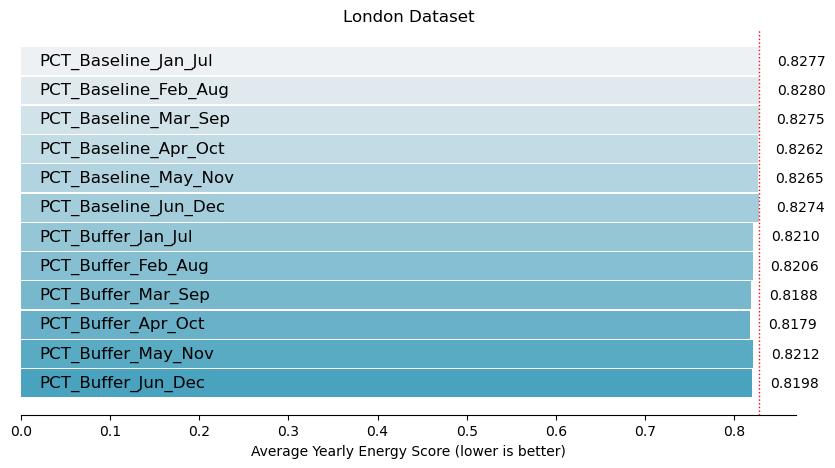

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('London Dataset')
plt.savefig('pictures/energy_score_comparison_london_2buffers.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()

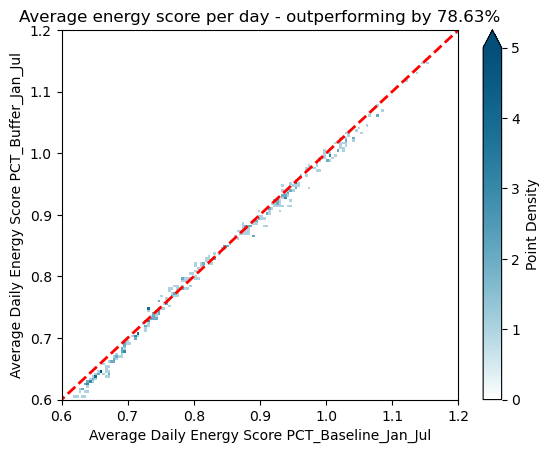

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 0]
technique_B = df_avg.iloc[:, 6]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline_Jan_Jul')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Jan_Jul')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(0.6, 1.2)
plt.ylim(0.6, 1.2)
# Show the plot
plt.savefig('pictures/londondailycomparison2buffers.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [20]:
for i in range(1,13):
    technique_A = df_avg.iloc[:, 0]
    technique_B = df_avg.iloc[:, i]
    percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
    percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
    print("lower in A: ", percentage_A_greater_than_B)

lower in A:  55.61643835616439
lower in A:  50.68493150684932
lower in A:  70.41095890410959
lower in A:  71.78082191780823
lower in A:  58.082191780821915
lower in A:  78.63013698630137
lower in A:  68.76712328767123
lower in A:  75.61643835616438
lower in A:  87.3972602739726
lower in A:  83.83561643835617
lower in A:  82.73972602739727
lower in A:  4.383561643835616


In [59]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Rename the index for clarity
monthly_means.index = techniques#['PCT January', 'PCT February', 'PCT March', 'PCT April', 'PCT May', 'PCT June', 'PCT July', 'PCT August', 'PCT September', 'PCT October', 'PCT November', 'PCT December']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,0.997153,0.983662,0.969528,0.841274,0.757343,0.713030,0.647069,0.660257,0.737815,0.788805,0.898125,0.949053
PCT_Baseline_Feb_Aug,0.998149,0.984541,0.969688,0.849533,0.760735,0.713484,0.645100,0.658848,0.735715,0.785999,0.897627,0.948114
PCT_Baseline_Mar_Sep,0.997146,0.984204,0.970235,0.841009,0.758300,0.714172,0.645813,0.659528,0.738311,0.786921,0.894790,0.950464
PCT_Baseline_Apr_Oct,0.995776,0.982402,0.968675,0.839985,0.756073,0.714328,0.643988,0.658034,0.736878,0.788309,0.895522,0.946001
PCT_Baseline_May_Nov,0.995988,0.982569,0.969032,0.841102,0.756944,0.712875,0.646396,0.659437,0.735371,0.786650,0.896507,0.946086
PCT_Baseline_Jun_Dec,0.997813,0.982944,0.970795,0.841924,0.758984,0.713076,0.645347,0.659173,0.738305,0.785617,0.898392,0.947469
PCT_Buffer_Jan_Jul,0.978408,0.973063,0.962528,0.843607,0.755219,0.700334,0.627231,0.648429,0.730633,0.799652,0.897296,0.946299
PCT_Buffer_Feb_Aug,0.973193,0.953111,0.952701,0.855239,0.762811,0.712813,0.633061,0.639182,0.733540,0.791944,0.899952,0.950146
PCT_Buffer_Mar_Sep,0.982205,0.962597,0.946966,0.836035,0.761069,0.708951,0.635492,0.646208,0.720515,0.784812,0.899363,0.951670
PCT_Buffer_Apr_Oct,0.984213,0.967269,0.950656,0.827773,0.752682,0.712882,0.640792,0.653785,0.724904,0.769559,0.893998,0.946889


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for i, v in enumerate(x):
        style = color_gradient(v, min(x), max(x), base_val)
        if i >= 6 and v < x[i - 6]:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_2Baselines Comparison</b>"))


# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,0.99715,0.98366,0.96953,0.84127,0.75734,0.71303,0.64707,0.66026,0.73781,0.78881,0.89813,0.94905
PCT_Baseline_Feb_Aug,0.99815,0.98454,0.96969,0.84953,0.76074,0.71348,0.64510,0.65885,0.73572,0.78600,0.89763,0.94811
PCT_Baseline_Mar_Sep,0.99715,0.98420,0.97024,0.84101,0.75830,0.71417,0.64581,0.65953,0.73831,0.78692,0.89479,0.95046
PCT_Baseline_Apr_Oct,0.99578,0.98240,0.96868,0.83999,0.75607,0.71433,0.64399,0.65803,0.73688,0.78831,0.89552,0.94600
PCT_Baseline_May_Nov,0.99599,0.98257,0.96903,0.84110,0.75694,0.71287,0.64640,0.65944,0.73537,0.78665,0.89651,0.94609
PCT_Baseline_Jun_Dec,0.99781,0.98294,0.97080,0.84192,0.75898,0.71308,0.64535,0.65917,0.73831,0.78562,0.89839,0.94747
PCT_Buffer_Jan_Jul,0.97841,0.97306,0.96253,0.84361,0.75522,0.70033,0.62723,0.64843,0.73063,0.79965,0.89730,0.94630
PCT_Buffer_Feb_Aug,0.97319,0.95311,0.95270,0.85524,0.76281,0.71281,0.63306,0.63918,0.73354,0.79194,0.89995,0.95015
PCT_Buffer_Mar_Sep,0.98221,0.96260,0.94697,0.83603,0.76107,0.70895,0.63549,0.64621,0.72051,0.78481,0.89936,0.95167
PCT_Buffer_Apr_Oct,0.98421,0.96727,0.95066,0.82777,0.75268,0.71288,0.64079,0.65378,0.72490,0.76956,0.89400,0.94689
